In [1]:
import os
if not os.path.exists("../data/processed/final_model_input.pkl"):
    print("WARNING: data/processed/final_model_input.pkl not found.")
    print("If you see this, re-run the feature/embedding notebook to create it,")
    print("or re-upload the file into data/processed/.")

In [10]:
import joblib
import numpy as np
import pandas as pd
import os
import time
import warnings
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
RANDOM_STATE = 42

In [11]:
try:
    import xgboost as xgb
except Exception:
    xgb = None

try:
    import lightgbm as lgb
except Exception:
    lgb = None

try:
    import shap
except Exception:
    shap = None

In [4]:
try:
    import shap
except Exception:
    shap = None

In [12]:
bundle = joblib.load("../data/processed/final_model_input.pkl")
X = bundle["X"]      # numpy array: (n_samples, n_features)
y = bundle["y"]      # numpy array: (n_samples,)
cols_info = bundle.get("columns", {})

print("Loaded feature matrix:", X.shape)
print("Loaded target vector:", y.shape)
print("Columns info:", cols_info)


Loaded feature matrix: (1000, 2048)
Loaded target vector: (1000,)
Columns info: {'text_dim': 384, 'amenity_dim': 384, 'image_dim': 1280}


In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (800, 2048) Test shape: (200, 2048)


In [14]:
def evaluate_and_print(name, model, Xtr, Xte, ytr, yte, do_print=True):
    t0 = time.time()
    model.fit(Xtr, ytr)
    t_train = time.time() - t0
    preds = model.predict(Xte)

   
    mse = mean_squared_error(yte, preds)         
    rmse = float(np.sqrt(mse))                  
    mae = mean_absolute_error(yte, preds)
    r2 = r2_score(yte, preds)

    if do_print:
        print(f"--- {name} ---")
        print(f"Train time: {t_train:.1f}s")
        print(f"RMSE: {rmse:.6f} | MAE: {mae:.6f} | R2: {r2:.6f}")
    return {"name": name, "model": model, "rmse": rmse, "mae": mae, "r2": r2, "preds": preds}

In [15]:
results = []

In [16]:
# Ridge regression (fast baseline)
ridge = Ridge(alpha=1.0, random_state=RANDOM_STATE)
res_ridge = evaluate_and_print("Ridge", ridge, X_train, X_test, y_train, y_test)
results.append(res_ridge)

--- Ridge ---
Train time: 0.1s
RMSE: 1.907853 | MAE: 0.869599 | R2: -0.203657


In [17]:
#Random Forest
rf = RandomForestRegressor(n_estimators=200, max_depth=12, random_state=RANDOM_STATE, n_jobs=-1)
res_rf = evaluate_and_print("RandomForest", rf, X_train, X_test, y_train, y_test)
results.append(res_rf)

--- RandomForest ---
Train time: 16.6s
RMSE: 1.464704 | MAE: 0.433236 | R2: 0.290565


In [18]:
# MLP (simple)
mlp = MLPRegressor(hidden_layer_sizes=(512, 256), learning_rate_init=1e-3,
                   max_iter=200, random_state=RANDOM_STATE)
res_mlp = evaluate_and_print("MLP", mlp, X_train, X_test, y_train, y_test)
results.append(res_mlp)

--- MLP ---
Train time: 15.4s
RMSE: 1.685003 | MAE: 0.633586 | R2: 0.061111


In [20]:
# XGBoost
if xgb is not None:
    xgb_model = xgb.XGBRegressor(n_estimators=500, learning_rate=0.05,
                                 max_depth=6, random_state=RANDOM_STATE, n_jobs=-1, verbosity=0)
    res_xgb = evaluate_and_print("XGBoost", xgb_model, X_train, X_test, y_train, y_test)
    results.append(res_xgb)
else:
    print("xgboost not installed — skipping XGBoost baseline.")


--- XGBoost ---
Train time: 31.1s
RMSE: 1.603068 | MAE: 0.383532 | R2: 0.150201


In [21]:
# LightGBM 
if lgb is not None:
    lgb_model = lgb.LGBMRegressor(n_estimators=500, learning_rate=0.05,
                                 num_leaves=31, random_state=RANDOM_STATE, n_jobs=-1)
    res_lgb = evaluate_and_print("LightGBM", lgb_model, X_train, X_test, y_train, y_test)
    results.append(res_lgb)
else:
    print("lightgbm not installed — skipping LightGBM baseline.")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 398021
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 1664
[LightGBM] [Info] Start training from score 15.419711
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

In [22]:
summary = pd.DataFrame([{"model": r["name"], "rmse": r["rmse"], "mae": r["mae"], "r2": r["r2"]} for r in results])
summary = summary.sort_values("rmse").reset_index(drop=True)
print("\nModel comparison (sorted by RMSE):\n", summary)


Model comparison (sorted by RMSE):
           model      rmse       mae        r2
0  RandomForest  1.464704  0.433236  0.290565
1      LightGBM  1.585445  0.505081  0.168782
2       XGBoost  1.603068  0.383532  0.150201
3       XGBoost  1.603068  0.383532  0.150201
4           MLP  1.685003  0.633586  0.061111
5         Ridge  1.907853  0.869599 -0.203657


In [23]:
# HYPERPARAMETER TUNING (small budget)
tuned_model = None
if xgb is not None:
    print("\nTuning XGBoost (randomized search, small budget)...")
    param_dist = {
        "n_estimators": [100, 300, 500],
        "learning_rate": [0.01, 0.03, 0.05],
        "max_depth": [4, 6, 8],
        "subsample": [0.6, 0.8, 1.0],
        "colsample_bytree": [0.6, 0.8, 1.0]
    }
    xgb_clf = xgb.XGBRegressor(random_state=RANDOM_STATE, n_jobs=-1, verbosity=0)
    rs = RandomizedSearchCV(xgb_clf, param_dist, n_iter=8, scoring="neg_mean_squared_error",
                             cv=3, random_state=RANDOM_STATE, n_jobs=-1, verbose=1)
    rs.fit(X_train, y_train)
    print("Best params XGBoost:", rs.best_params_)
    tuned_model = rs.best_estimator_
    res_tuned = evaluate_and_print("XGBoost_tuned", tuned_model, X_train, X_test, y_train, y_test, do_print=True)
    results.append(res_tuned)

elif lgb is not None:
    print("\nTuning LightGBM (randomized search, small budget)...")
    param_dist = {
        "n_estimators": [100, 300, 500],
        "learning_rate": [0.01, 0.03, 0.05],
        "num_leaves": [31, 63, 127],
        "min_child_samples": [5, 10, 20]
    }
    lgb_clf = lgb.LGBMRegressor(random_state=RANDOM_STATE, n_jobs=-1)
    rs = RandomizedSearchCV(lgb_clf, param_dist, n_iter=8, scoring="neg_mean_squared_error",
                             cv=3, random_state=RANDOM_STATE, n_jobs=-1, verbose=1)
    rs.fit(X_train, y_train)
    print("Best params LightGBM:", rs.best_params_)
    tuned_model = rs.best_estimator_
    res_tuned = evaluate_and_print("LightGBM_tuned", tuned_model, X_train, X_test, y_train, y_test, do_print=True)
    results.append(res_tuned)
else:
    print("Neither XGBoost nor LightGBM available to tune (or you chose to skip).")


Tuning XGBoost (randomized search, small budget)...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best params XGBoost: {'subsample': 0.6, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.6}
--- XGBoost_tuned ---
Train time: 12.4s
RMSE: 1.365378 | MAE: 0.471243 | R2: 0.383521


In [24]:
best = min(results, key=lambda r: r["rmse"])
print(f"\nBest model by RMSE: {best['name']} (RMSE={best['rmse']:.6f})")

os.makedirs("../models", exist_ok=True)
best_model_filename = f"../models/best_model_{best['name']}.joblib"
joblib.dump(best["model"], best_model_filename)
print("Saved best model to:", best_model_filename)


Best model by RMSE: XGBoost_tuned (RMSE=1.365378)
Saved best model to: ../models/best_model_XGBoost_tuned.joblib


In [25]:
if shap is None:
    print("shap not installed — skipping SHAP explainability.")
else:
    try:
       
        tree_like = (isinstance(best["model"], RandomForestRegressor) or
                     (xgb is not None and isinstance(best["model"], xgb.XGBRegressor)) or
                     (lgb is not None and isinstance(best["model"], lgb.LGBMRegressor)))
        if tree_like:
            explainer = shap.TreeExplainer(best["model"])
            sample_idx = np.random.choice(np.arange(X_test.shape[0]), size=min(200, X_test.shape[0]), replace=False)
            shap_values = explainer.shap_values(X_test[sample_idx])
            # summary plot
            shap.summary_plot(shap_values, X_test[sample_idx], feature_names=None, show=True)
            joblib.dump(shap_values, "models/shap_values_sample.joblib")
            print("Saved SHAP sample to models/shap_values_sample.joblib")
        else:
            
            background = shap.sample(X_train, 100)
            explainer = shap.KernelExplainer(best["model"].predict, background)
            shap_vals = explainer.shap_values(X_test[:50])
            joblib.dump(shap_vals, "models/shap_values_kernel_sample.joblib")
            print("Saved Kernel SHAP sample to models/shap_values_kernel_sample.joblib")
    except Exception as e:
        print("SHAP explainability failed:", e)

SHAP explainability failed: could not convert string to float: '[1.5419711E1]'


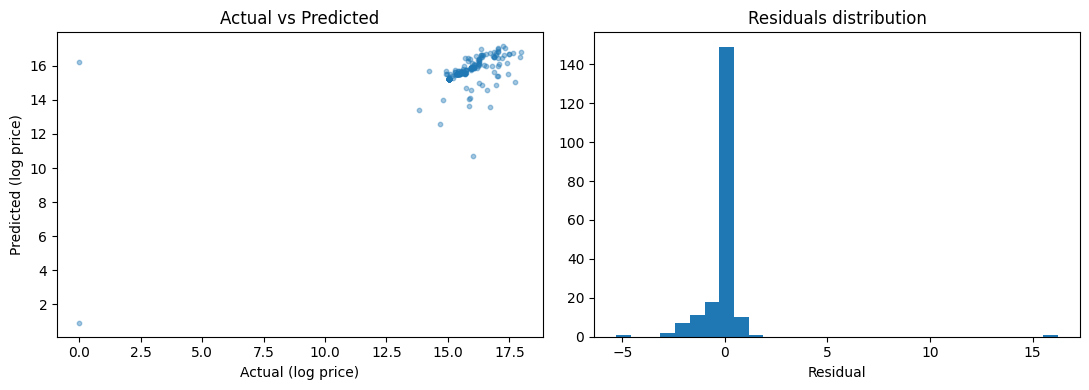

In [26]:
best_mod = best["model"]
preds = best_mod.predict(X_test)
residuals = preds - y_test

plt.figure(figsize=(11,4))
plt.subplot(1,2,1)
plt.scatter(y_test, preds, alpha=0.4, s=10)
plt.xlabel("Actual (log price)")
plt.ylabel("Predicted (log price)")
plt.title("Actual vs Predicted")

plt.subplot(1,2,2)
plt.hist(residuals, bins=30)
plt.title("Residuals distribution")
plt.xlabel("Residual")
plt.tight_layout()
plt.show()

In [28]:
metrics = {
    "model": best["name"],
    "rmse": best["rmse"],
    "mae": best["mae"],
    "r2": best["r2"]
}
os.makedirs("../results", exist_ok=True)
joblib.dump({"metrics": metrics, "y_test": y_test, "y_pred": preds}, "../results/model_results.joblib")
print("Saved results to results/model_results.joblib")
print("Metrics:", metrics)

Saved results to results/model_results.joblib
Metrics: {'model': 'XGBoost_tuned', 'rmse': 1.365377685333351, 'mae': 0.4712433509534344, 'r2': 0.38352085030338934}
